<a href="https://colab.research.google.com/github/radustefannicolae/Cancer-AI/blob/main/MRI_Brain_Tumor_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Găsirea dataset-ului pentru detectarea tumorilor pe baza imagisticii prin rezonanță magnetică (IRM)


Datasetul se gaseste la: " https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

In [15]:
!pip install kaggle

In [16]:
from google.colab import files
files.upload()

{}

In [17]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/brain-mri-images-for-brain-tumor-detection-metadata.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/brain-mri-images-for-brain-tumor-detection-metadata.json': No such file or directory


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import zipfile
import os


with zipfile.ZipFile("Brain MRI Images for Brain Tumor Detection.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

# Listarea fișierele pentru a verifica dezarhivarea
os.listdir("./data")


['yes', 'no', 'brain_tumor_dataset']

# Import packages

In [20]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

## Reading the Images

In [21]:
tumor = []
healthy = []
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [22]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [23]:
healthy.shape

(85, 128, 128, 3)

In [24]:
tumor.shape

(86, 128, 128, 3)

In [25]:
np.random.choice(10, 5, replace=False)

array([4, 6, 9, 5, 2])

# Visualizing Brain MRI Images

In [26]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])





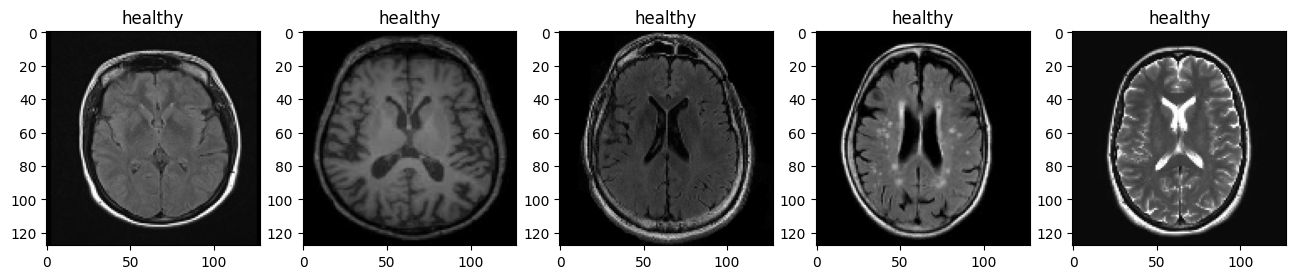

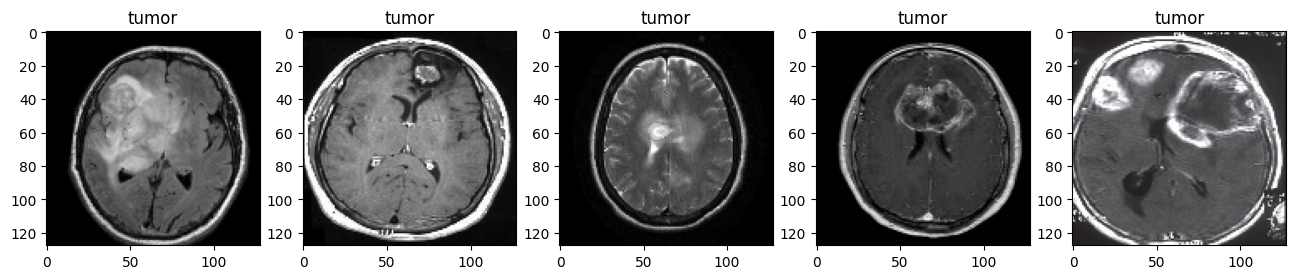

In [27]:
plot_random(healthy, tumor, num=5)

 # Create Torch Dataset Class

## What is Pytorch's Abstract Dataset Class

In [28]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

## Creating MRI cutom dataset class

In [29]:
class MRI(Dataset):
    def __init__(self):

        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):

        sample = {'image': self.images[index], 'label':self.labels[index]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

In [30]:
mri_dataset = MRI()
mri_dataset.normalize()

# Creating a dataloader

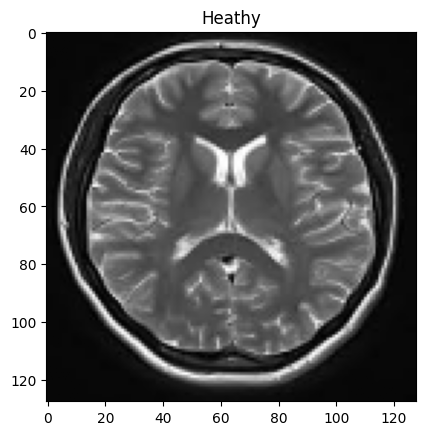

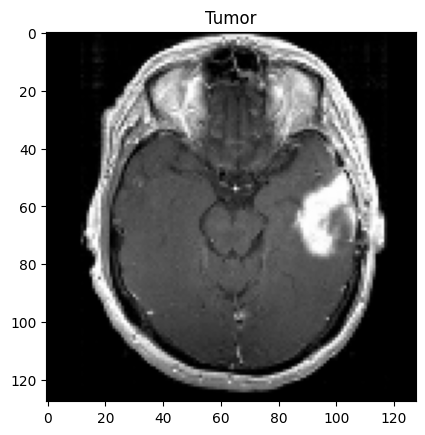

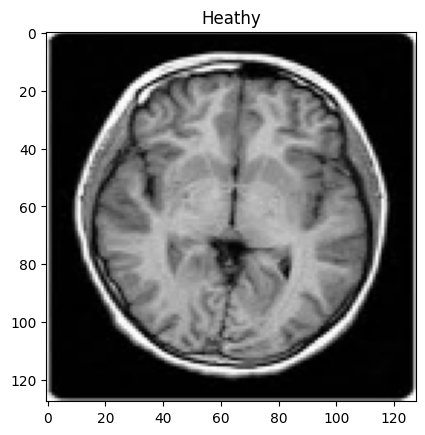

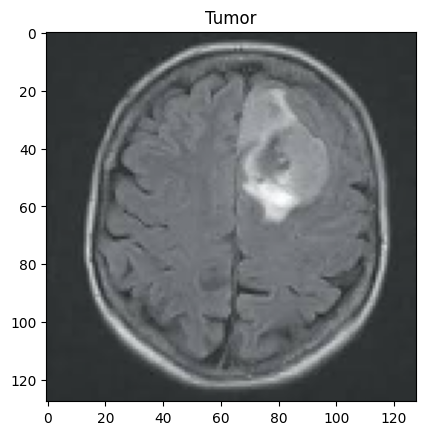

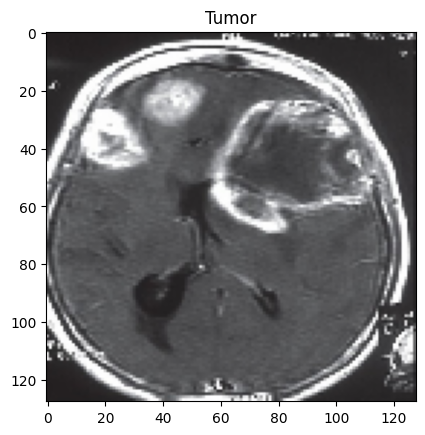

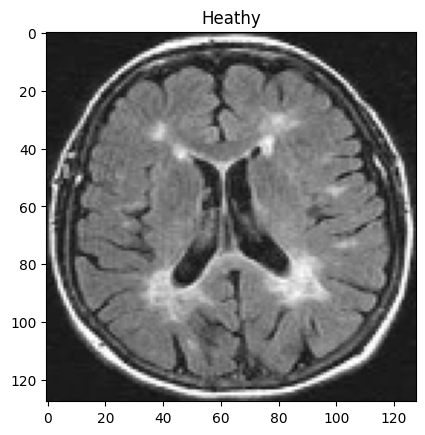

In [31]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# Create a model

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x


# Some Basics of Training and Evaluation in Pytorch

## model.eval()

- Folosit în special pentru inferență **NU ARE NIMIC DE-A FACE cu gradientii!!!**
- schimbă comportamentul metodei `forward()` a modulului asupra căruia este apelat, de exemplu, dezactivează dropout-ul și face ca normalizarea batch-urilor să utilizeze statisticile întregii populații. Acest lucru este necesar pentru inferență





## model.train()

Activează dropout-ul și normalizarea batch-urilor (adică, modul de antrenament).
Gradienții sunt calculați

## numpy array vs tensor

Diferența dintre un array NumPy și un tensor este că tensorii sunt susținuți de memoria acceleratorului, cum ar fi GPU, și sunt imutabili, spre deosebire de array-urile NumPy. Nu poți actualiza niciodată un tensor, ci trebuie să creezi unul nou. Dacă te interesează învățarea automată sau vei fi implicat în acest domeniu, un tensor este o alegere potrivită dacă vei folosi GPU. Un tensor poate rezida în memoria acceleratorului.

Array-urile NumPy reprezintă funcționalitatea de bază a pachetului NumPy, conceput pentru a susține operațiuni matematice mai rapide. Spre deosebire de structura de date listă încorporată în Python, acestea pot conține doar elemente de un singur tip de date. Biblioteci precum Pandas, care sunt utilizate pentru preprocesarea datelor, sunt construite în jurul array-urilor NumPy. Tensorii PyTorch sunt similari cu array-urile NumPy, dar pot fi operați și pe GPU-uri Nvidia compatibile cu CUDA.
Array-urile NumPy sunt utilizate în principal în algoritmi tipici de învățare automată (cum ar fi k-means sau Arborele de Decizie în scikit-learn), în timp ce tensorii PyTorch sunt utilizați în principal în învățarea profundă, care necesită calcule matriceale intense.
Spre deosebire de array-urile NumPy, atunci când creezi un tensor PyTorch, acesta acceptă și doi alți argumenti numiți device_type (dacă calculul se întâmplă pe CPU sau GPU) și requires_grad (care este folosit pentru a calcula derivatele).

## torch.tensor vs. torch.cuda.tensor

Diferența cheie este că torch.Tensor ocupă memoria CPU, în timp ce torch.cuda.Tensor ocupă memoria GPU. Desigur, operațiunile pe un Tensor CPU sunt calculate cu CPU, în timp ce operațiunile pentru Tensorul GPU / CUDA sunt calculate pe GPU.


In [37]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.4294, 0.5984, 0.6173, 0.7476, 0.7461, 0.6152, 0.6803, 0.6361, 0.3934,
        0.0048]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.4294, 0.5984, 0.6173, 0.7476, 0.7461, 0.6152, 0.6803, 0.6361, 0.3934,
        0.0048]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([1.8439e-01, 3.5809e-01, 3.8105e-01, 5.5889e-01, 5.5670e-01, 3.7844e-01,
        4.6280e-01, 4.0466e-01, 1.5476e-01, 2.3357e-05])


Deoarece interfața hardware de bază este complet diferită, Tensorii CPU sunt compatibili doar cu Tensorii CPU și, invers, Tensorii GPU sunt compatibili doar cu Tensorii GPU.

### In ce scenariu este torch.cuda.Tensor() necesar?

Când dorești să folosești accelerarea GPU (care este mult mai rapidă în majoritatea cazurilor) pentru programul tău, trebuie să folosești torch.cuda.Tensor, dar trebuie să te asiguri că TOȚI tensorii pe care îi folosești sunt Tensori CUDA, deoarece mixarea nu este posibilă aici.

### tensor.cpu().detach().numpy(): Convert Pytorch tensor to Numpy array

Așa cum am menționat anterior, obiectul np.ndarray nu are acest strat suplimentar de "grafic computațional" și, prin urmare, când convertești un torch.tensor într-un np.ndarray, trebuie să elimini explicit graficul computațional al tensorului folosind comanda detach().
.cpu() returnează o copie a acestui obiect în memoria CPU.

# Evaluate a New-Born Neural Network!

In [38]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN().to(device)

Using device: cpu


In [39]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [40]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())



In [41]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [42]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [43]:
accuracy_score(y_true, threshold(outputs))

0.49707602339181284

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

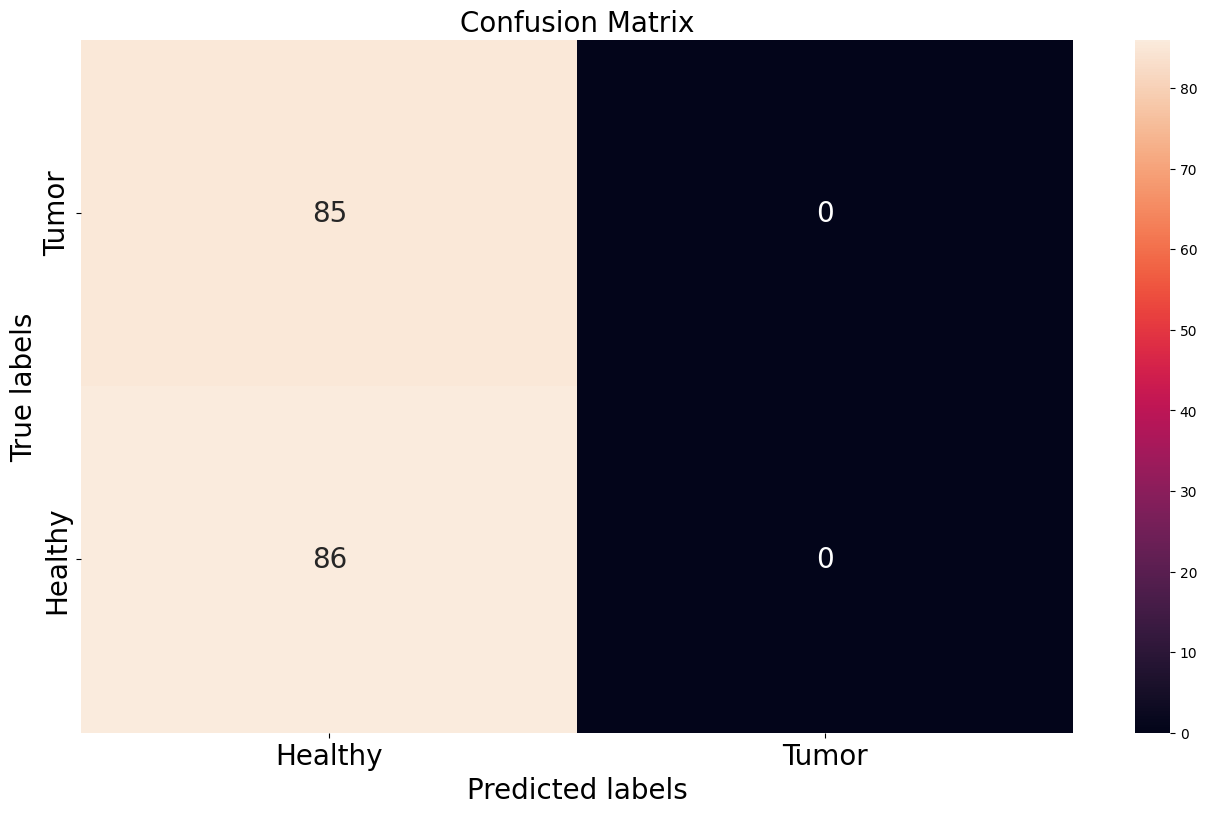

In [44]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

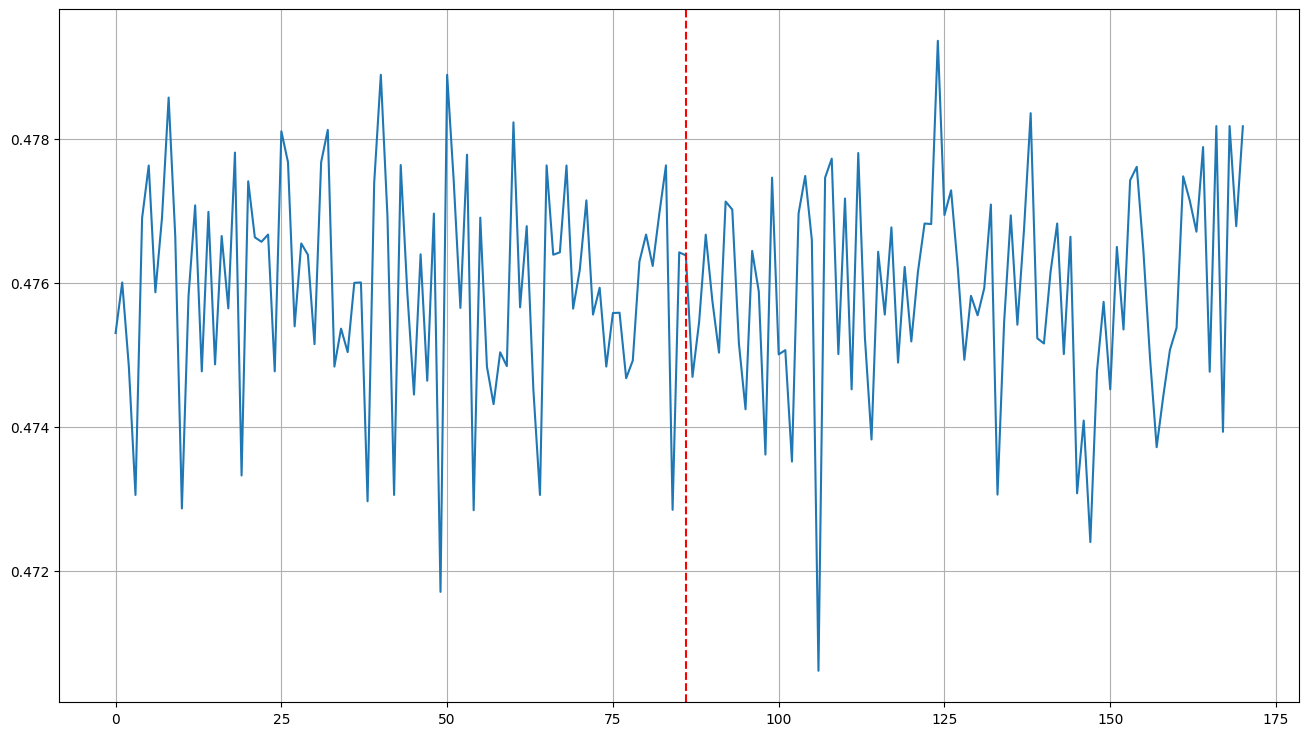

In [45]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Train the dumb model

In [46]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [47]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.676707
Train Epoch: 20	Loss: 0.651389
Train Epoch: 30	Loss: 0.609332
Train Epoch: 40	Loss: 0.549681
Train Epoch: 50	Loss: 0.471708
Train Epoch: 60	Loss: 0.438893
Train Epoch: 70	Loss: 0.459785
Train Epoch: 80	Loss: 0.390994
Train Epoch: 90	Loss: 0.357009
Train Epoch: 100	Loss: 0.365599
Train Epoch: 110	Loss: 0.321411
Train Epoch: 120	Loss: 0.315591
Train Epoch: 130	Loss: 0.334506
Train Epoch: 140	Loss: 0.314716
Train Epoch: 150	Loss: 0.269048
Train Epoch: 160	Loss: 0.254923
Train Epoch: 170	Loss: 0.262479
Train Epoch: 180	Loss: 0.208607
Train Epoch: 190	Loss: 0.184872
Train Epoch: 200	Loss: 0.163387
Train Epoch: 210	Loss: 0.146060
Train Epoch: 220	Loss: 0.137789
Train Epoch: 230	Loss: 0.149319
Train Epoch: 240	Loss: 0.109000
Train Epoch: 250	Loss: 0.096731
Train Epoch: 260	Loss: 0.071528
Train Epoch: 270	Loss: 0.062178
Train Epoch: 280	Loss: 0.050698
Train Epoch: 290	Loss: 0.046546
Train Epoch: 300	Loss: 0.036565
Train Epoch: 310	Loss: 0.032380
Train Epoch: 320	

# Evaluate a smart model

In [48]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [49]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

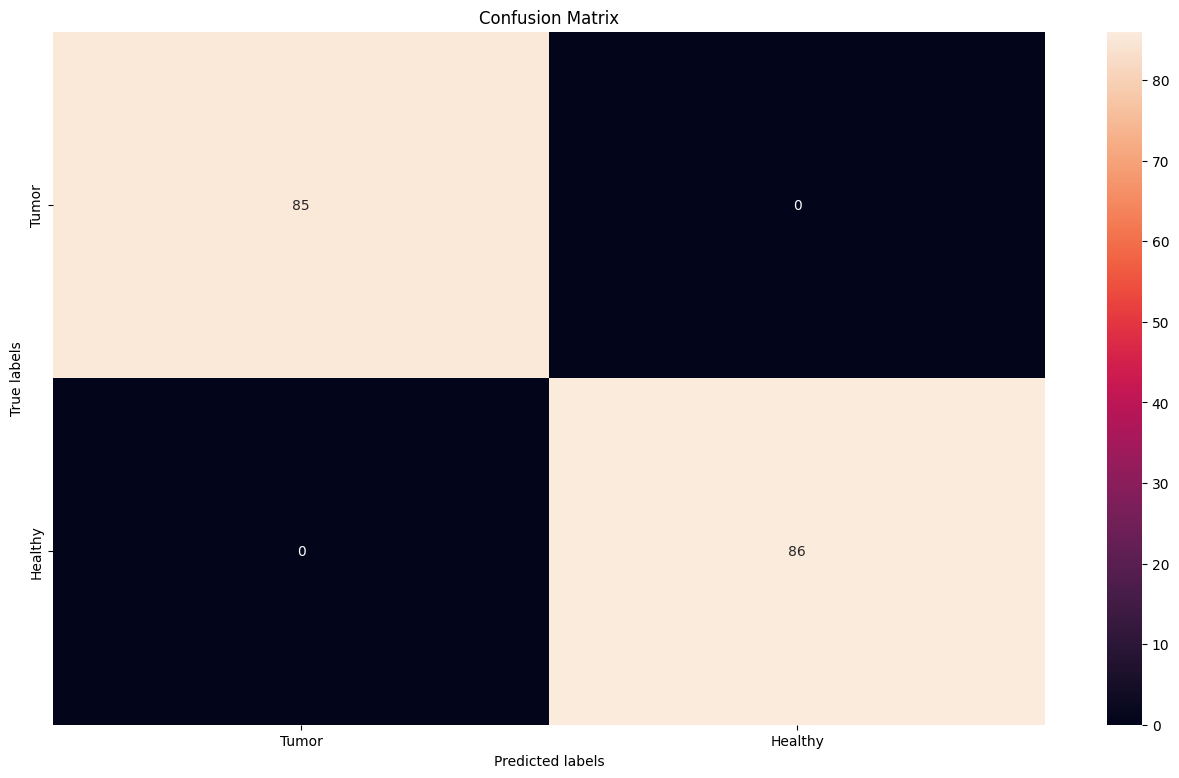

In [50]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

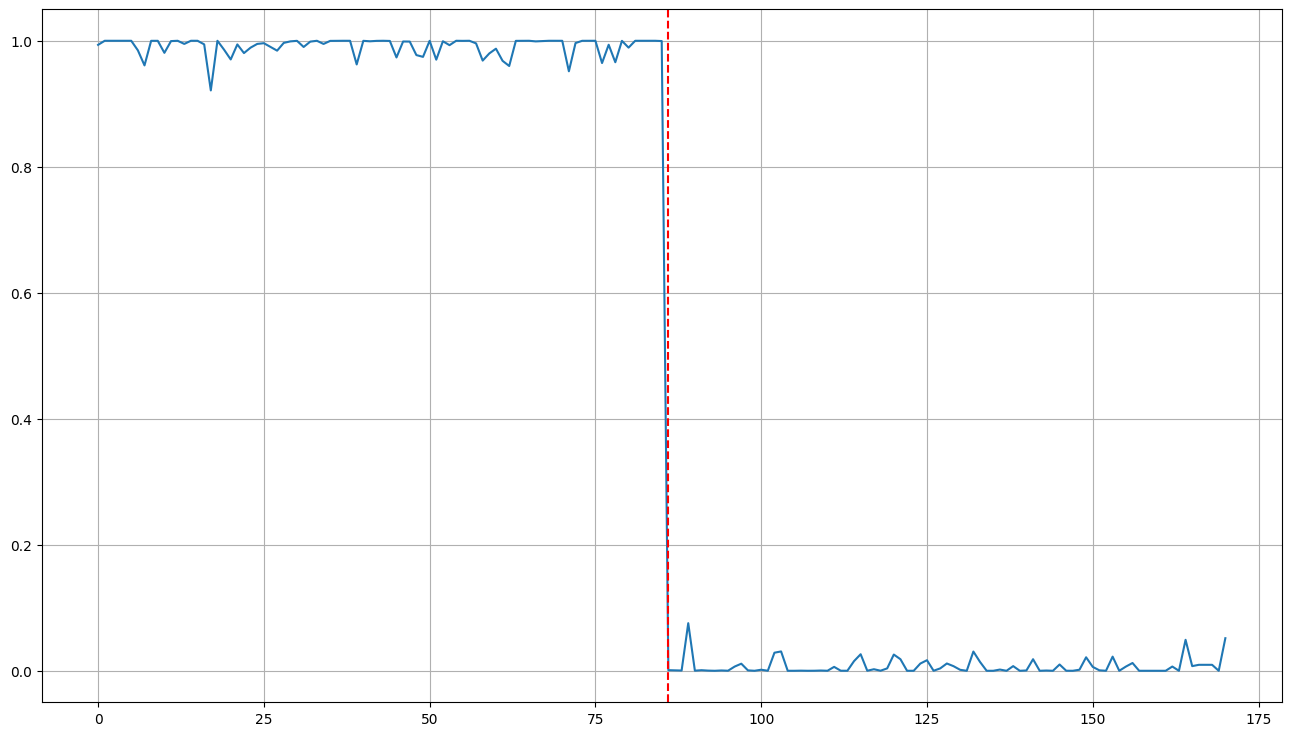

In [51]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [52]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [53]:
no_of_layers = 0
conv_layers = []

In [54]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [55]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [56]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

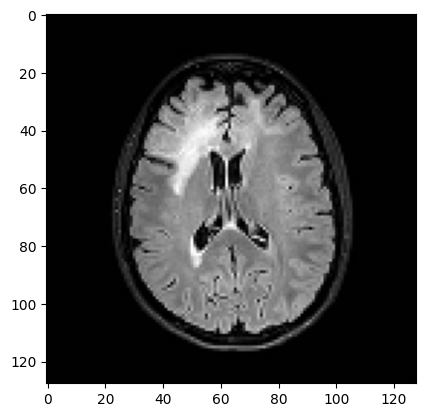

In [57]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [58]:
img = torch.from_numpy(img).to(device)

In [59]:
img.shape

torch.Size([3, 128, 128])

In [60]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [61]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


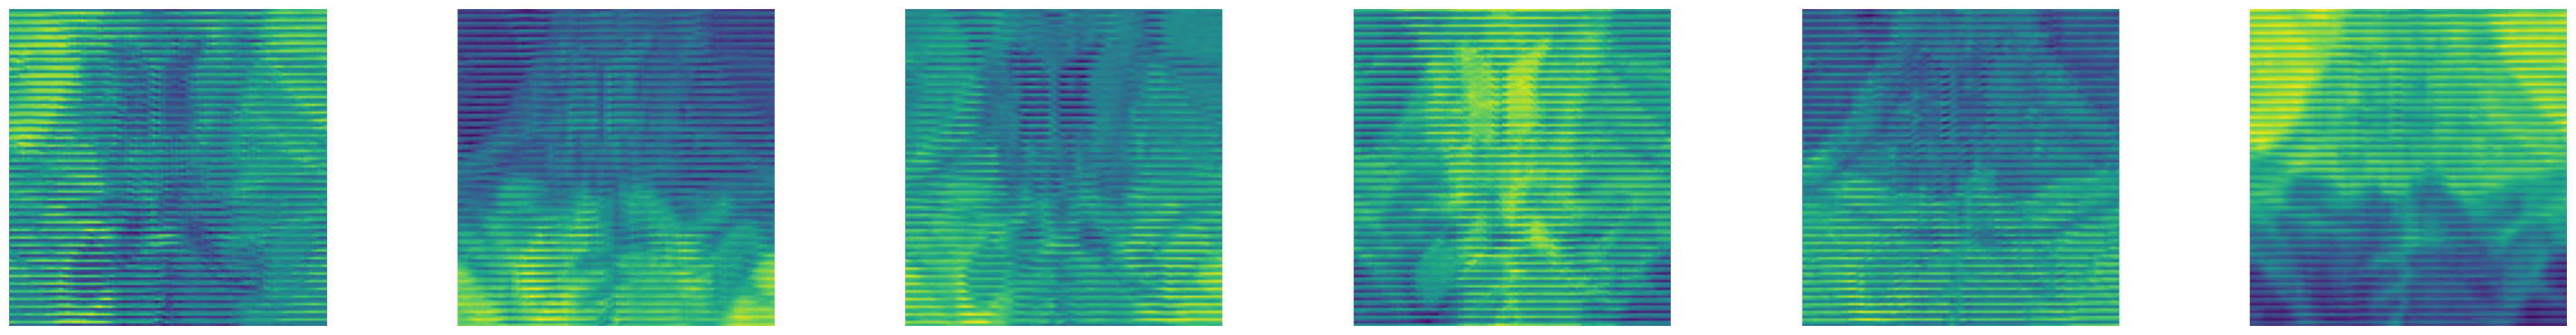

Layer  2


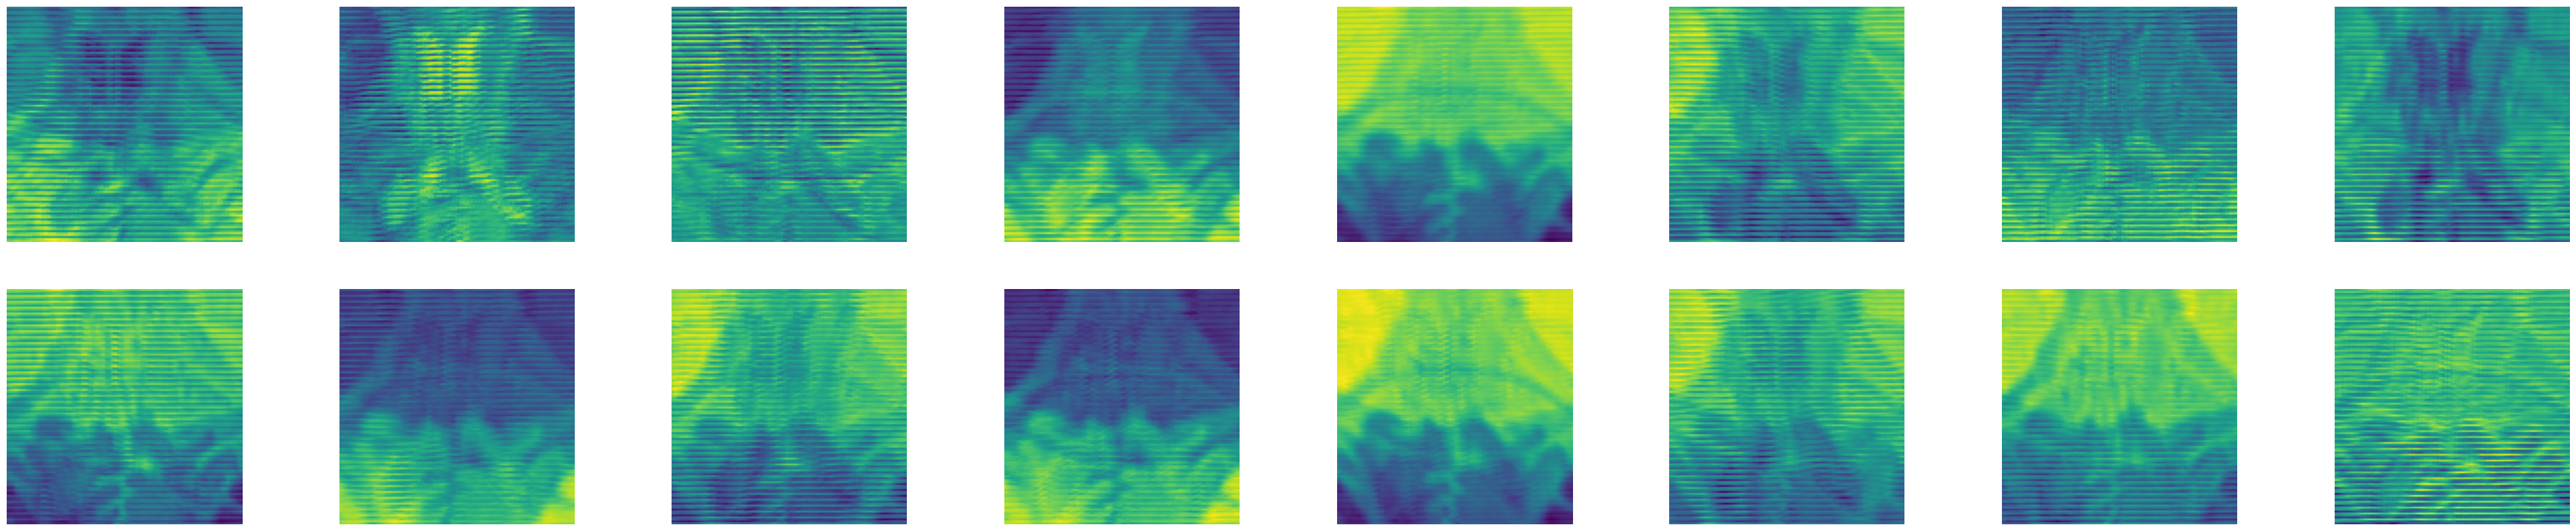

In [62]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# Are We Over-fitting?

## Preparing a validation set: We need to change the MRI dataset slightly!

Vom face mici modificări la clasa noastră de dataset **MRI dataset class**:

- Definirea unei funcții pentru a împărți datele în seturi de antrenament și validare
- Definirea unei variabile numite **mode** pentru a determina dacă suntem interesați de datele de antrenament SAU de validare
- Modificarea funcțiilor **`__len__()`** și **`__getitem__()`** și condiționarea lor în funcție de variabila **mode**



In [63]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [64]:
class MRI(Dataset):

    def __init__(self):

        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None

        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'

        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}

        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}

        return sample

    def normalize(self):
        self.images = self.images/255.0

# Are we overfitting?

In [65]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [66]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [68]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN().to(device)

Using device: cpu


In [69]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [70]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [71]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    epoch_train_loss.append(np.mean(train_losses))

    # validate for the current epoch
    val_losses = []
    model.eval()

    mri_dataset.mode = 'val'

    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))


Train Epoch: 10	Train Loss: 0.680820	Val Loss: 0.700651
Train Epoch: 20	Train Loss: 0.651481	Val Loss: 0.675601
Train Epoch: 30	Train Loss: 0.599379	Val Loss: 0.643253
Train Epoch: 40	Train Loss: 0.585694	Val Loss: 0.638517
Train Epoch: 50	Train Loss: 0.540150	Val Loss: 0.639587
Train Epoch: 60	Train Loss: 0.563460	Val Loss: 0.640511
Train Epoch: 70	Train Loss: 0.521562	Val Loss: 0.648876
Train Epoch: 80	Train Loss: 0.503959	Val Loss: 0.646475
Train Epoch: 90	Train Loss: 0.454290	Val Loss: 0.658458
Train Epoch: 100	Train Loss: 0.457039	Val Loss: 0.657845
Train Epoch: 110	Train Loss: 0.434246	Val Loss: 0.667673
Train Epoch: 120	Train Loss: 0.411699	Val Loss: 0.672797
Train Epoch: 130	Train Loss: 0.397091	Val Loss: 0.675843
Train Epoch: 140	Train Loss: 0.337886	Val Loss: 0.678988
Train Epoch: 150	Train Loss: 0.362548	Val Loss: 0.700416
Train Epoch: 160	Train Loss: 0.353350	Val Loss: 0.718897
Train Epoch: 170	Train Loss: 0.293965	Val Loss: 0.753120
Train Epoch: 180	Train Loss: 0.312726	Va

Text(0, 0.5, 'Loss')

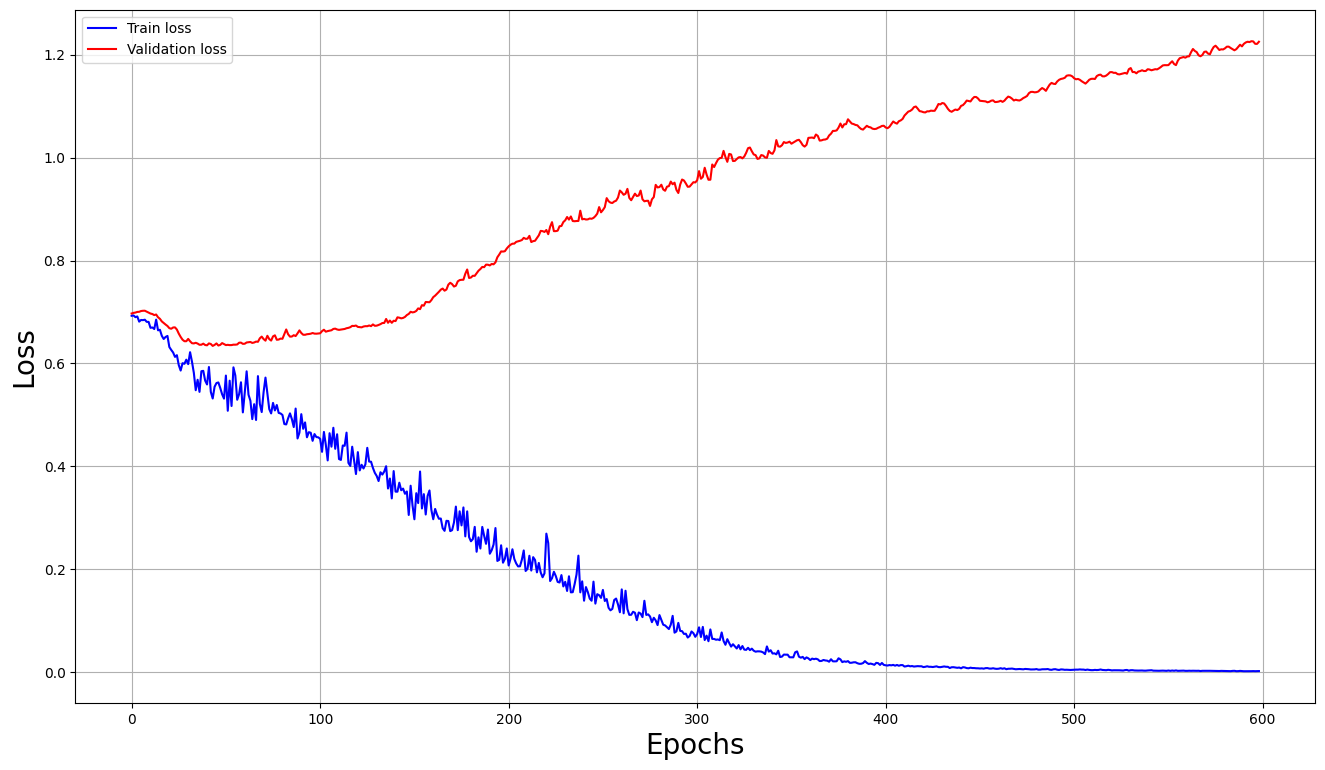

In [72]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)